In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE #Note: SMOTE was not used in the final project due to runtime issues

# The dataset can be downloaded from: 
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

# Load the dataset (assuming you've downloaded it)
df = pd.read_csv('../data/creditcard.csv')

# Basic dataset exploration
print(f"Dataset shape: {df.shape}")
print(f"Number of fraudulent transactions: {df['Class'].sum()}")
print(f"Percentage of fraudulent transactions: {df['Class'].mean() * 100:.4f}%")

# Convert 'Time' to datetime format for better interpretation
# The 'Time' feature is in seconds since the first transaction
# Let's create a proper timestamp starting from a reference date
reference_date = pd.Timestamp('2013-09-01')  # Using the month mentioned in dataset description
df['Timestamp'] = reference_date + pd.to_timedelta(df['Time'], unit='s')

# Check the timespan of the dataset
print(f"Dataset timespan: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
print(f"Dataset duration: {(df['Timestamp'].max() - df['Timestamp'].min()).days} days and "
      f"{(df['Timestamp'].max() - df['Timestamp'].min()).seconds // 3600} hours")

# Split the dataset chronologically (70% train, 30% test)
df = df.sort_values('Time')
train_size = int(0.7 * len(df))
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Prepare features and target
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
           'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
           'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
X_train = train_df[features]
y_train = train_df['Class']
X_test = test_df[features]
y_test = test_df['Class']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a classifier
print("Training Random Forest classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight={0: 1, 1: 10})
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred))

# Create time intervals for drift detection
def create_time_intervals(data, n_intervals=6):
    """Create equal-sized time intervals from data for drift detection."""
    # Sort by time
    data = data.sort_values('Time')
    
    # Split into equal intervals
    interval_size = len(data) // n_intervals
    intervals = []
    
    for i in range(n_intervals):
        start_idx = i * interval_size
        end_idx = (i + 1) * interval_size if i < n_intervals - 1 else len(data)
        intervals.append(data.iloc[start_idx:end_idx])
    
    return intervals

# Create intervals for drift detection
intervals = create_time_intervals(test_df, n_intervals=6)  # Create 6 intervals

print(f"Created {len(intervals)} time intervals for drift detection")
for i, interval in enumerate(intervals):
    start_time = interval['Timestamp'].min()
    end_time = interval['Timestamp'].max()
    fraud_rate = interval['Class'].mean() * 100
    print(f"Interval {i+1}: {start_time} to {end_time}, {len(interval)} samples, Fraud rate: {fraud_rate:.4f}%")

Dataset shape: (284807, 31)
Number of fraudulent transactions: 492
Percentage of fraudulent transactions: 0.1727%
Dataset timespan: 2013-09-01 00:00:00 to 2013-09-02 23:59:52
Dataset duration: 1 days and 23 hours
Training Random Forest classifier...
Model Accuracy: 0.9996
Precision: 1.0000
Recall: 0.6759
F1 Score: 0.8066
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       1.00      0.68      0.81       108

    accuracy                           1.00     85443
   macro avg       1.00      0.84      0.90     85443
weighted avg       1.00      1.00      1.00     85443

Created 6 time intervals for drift detection
Interval 1: 2013-09-02 12:55:29 to 2013-09-02 14:42:00, 14240 samples, Fraud rate: 0.0983%
Interval 2: 2013-09-02 14:42:00 to 2013-09-02 16:20:45, 14240 samples, Fraud rate: 0.1334%
Interval 3: 2013-09-02 16:20:47 to 2013-09-02 18:02:08, 14240 samples, Fraud rate: 0.1615%
Interval 4: 2013-09-02 18:02:08 


Random Forest - Model Predicting Credit Card Fraud Feature Ranking:
----------------------------------------
1. V17 (0.1413)
2. V10 (0.1386)
3. V14 (0.1327)
4. V12 (0.1261)
5. V11 (0.0908)
6. V16 (0.0838)
7. V4 (0.0476)
8. V7 (0.0306)
9. V18 (0.0295)
10. V3 (0.0272)
11. V9 (0.0154)
12. V5 (0.0128)
13. V1 (0.0110)
14. V6 (0.0100)
15. V19 (0.0094)
16. V2 (0.0092)
17. V21 (0.0084)
18. Amount (0.0080)
19. V26 (0.0075)
20. V13 (0.0071)
21. V8 (0.0067)
22. V20 (0.0066)
23. V23 (0.0062)
24. V15 (0.0062)
25. V28 (0.0060)
26. V25 (0.0055)
27. V22 (0.0055)
28. V27 (0.0053)
29. V24 (0.0050)


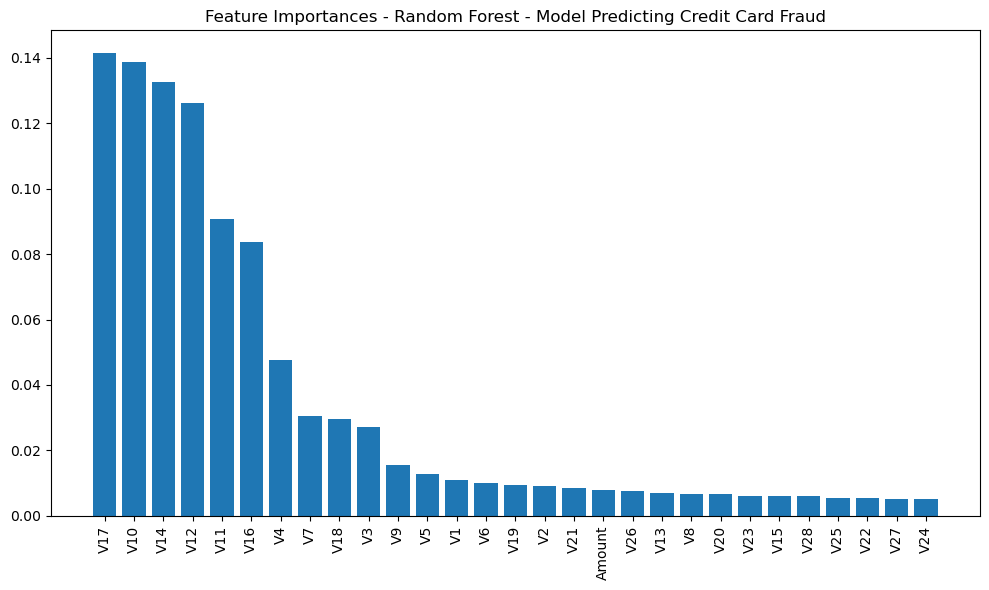

In [2]:
# After training each random forest classifier
def print_feature_importance(model, feature_names, model_name="Random Forest"):
    """
    Print and visualize feature importances for a trained random forest model
    
    Parameters:
    -----------
    model : RandomForestClassifier
        The trained model to analyze
    feature_names : list
        List of feature names corresponding to the input features
    model_name : str
        Name of the model for display purposes
    """
    # Get feature importances
    importances = model.feature_importances_
    
    # Sort feature importances in descending order and get corresponding indices
    indices = np.argsort(importances)[::-1]
    
    # Print feature ranking
    print(f"\n{model_name} Feature Ranking:")
    print("-" * 40)
    for i, idx in enumerate(indices):
        print(f"{i+1}. {feature_names[idx]} ({importances[idx]:.4f})")
    
    # Create a bar chart of feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances - {model_name}")
    plt.bar(range(len(feature_names)), importances[indices], align="center")
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Example usage for each of your random forest models:
# Assuming X_train contains your features and columns gives feature names
feature_names = X_train.columns.tolist()  # Adjust if using a different data structure

# For each model you've trained
print_feature_importance(model, feature_names, "Random Forest - Model Predicting Credit Card Fraud")

In [6]:
## Fit Simplier Model with only Top 14 Features (cutoff at >= 1% IV)

# Isolate important features (Note: We reusing namespaces to ensure capability with scenarios below)
importances = model.feature_importances_
feature_names = X_train.columns.tolist()

# Sort feature importances in descending order and get corresponding indices
indices = np.argsort(importances)[::-1]
features_ranked = []
for idx in indices:
    features_ranked.append(feature_names[idx])

# features_ranked[:14]

# Prepare features and target
features = features_ranked[:14]
X_train = train_df[features]
y_train = train_df['Class']
X_test = test_df[features]
y_test = test_df['Class']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a classifier
print("Training Random Forest classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight={0: 1, 1: 10})
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred))


Training Random Forest classifier...
Model Accuracy: 0.9996
Precision: 1.0000
Recall: 0.7037
F1 Score: 0.8261
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       1.00      0.70      0.83       108

    accuracy                           1.00     85443
   macro avg       1.00      0.85      0.91     85443
weighted avg       1.00      1.00      1.00     85443




Random Forest - Model with Feature Selection Predicting Credit Card Fraud Feature Ranking:
----------------------------------------
1. V17 (0.2489)
2. V10 (0.1496)
3. V14 (0.1383)
4. V12 (0.1152)
5. V11 (0.0937)
6. V16 (0.0666)
7. V4 (0.0356)
8. V3 (0.0343)
9. V18 (0.0301)
10. V9 (0.0254)
11. V7 (0.0233)
12. V1 (0.0144)
13. V6 (0.0130)
14. V5 (0.0117)


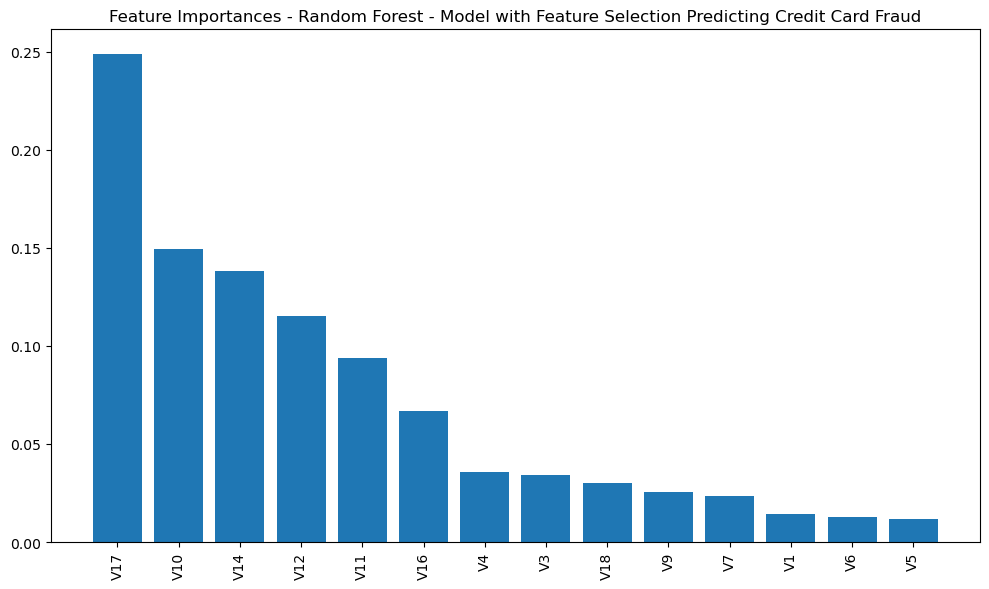

In [20]:
# For each model you've trained (this time just model with simple feature selection)
print_feature_importance(model, features_ranked[:14], "Random Forest - Model with Feature Selection Predicting Credit Card Fraud")

In [21]:
# Import necessary libraries for drift detection
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
import numpy as np
from sklearn.neighbors import KernelDensity

def calculate_wasserstein_distance(dist1, dist2):
    """Calculate Wasserstein distance between two distributions."""
    return wasserstein_distance(dist1, dist2)

def calculate_kl_divergence(dist1, dist2, n_bins=30):
    """
    Calculate KL divergence between two distributions.
    Using Jensen-Shannon divergence as a symmetric alternative to KL.
    
    Args:
        dist1: First distribution samples
        dist2: Second distribution samples
        n_bins: Number of bins for discretization
    """
    # Convert continuous distributions to discrete probability distributions
    hist1, bin_edges = np.histogram(dist1, bins=n_bins, density=True)
    hist2, _ = np.histogram(dist2, bins=bin_edges, density=True)
    
    # Normalize to create probability distributions
    bin_width = bin_edges[1] - bin_edges[0]
    p = hist1 * bin_width
    q = hist2 * bin_width
    
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    
    # Normalize again to ensure probabilities sum to 1
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    # Calculate Jensen-Shannon divergence (symmetric version of KL)
    js_distance = jensenshannon(p, q)
    
    # Return JS divergence (which is the square root of JS distance)
    return js_distance ** 2

def estimate_fisher_information(samples, bandwidth=0.1):
    """Estimate Fisher Information Matrix for a set of samples."""
    # For univariate data, Fisher Information is the negative expectation of 
    # the second derivative of the log-likelihood
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(samples.reshape(-1, 1))
    
    # Estimate density at sample points
    log_density = kde.score_samples(samples.reshape(-1, 1))
    density = np.exp(log_density)
    
    # Calculate Fisher Information (simplified for univariate case)
    # For KDE, this approximates to: ∫ (∇log p(x))² p(x) dx
    grad_log_density = np.gradient(log_density)
    grad_samples = np.gradient(samples)
    
    # Avoid division by zero
    valid_indices = np.abs(grad_samples) > 1e-10
    if np.sum(valid_indices) > 0:
        grad_log_p = grad_log_density[valid_indices] / grad_samples[valid_indices]
        fisher_info = np.mean(grad_log_p ** 2)
    else:
        # If all gradients are near zero, use an alternative approach
        fisher_info = np.var(log_density)  # A reasonable proxy
    
    return fisher_info

def detect_distribution_drift(intervals, features, scenario='interval', test_data=[]):
    """Detect drift between consecutive time intervals."""
    results = []
    
    if scenario=='interval':
        counter = len(intervals) - 1
    else:
        counter = len(intervals)

    # For each pair of consecutive intervals
    for i in range(counter):
    # for i in range(1):

        # print(f"Comparing Interval {i+1} vs Interval {i+2}:")
        # interval_drifts = []
        
        # # Get the data for current and next interval
        # current_data = intervals[i]
        # next_data = intervals[i+1]

        # # Helper procedure to ensure datasets are same size (if needed)
        # if len(current_data) != len(next_data):
        #     next_data = next_data[:len(current_data)]

        # Scenario 3 [Main Scenario]: Temporal shifts between Interval
        if scenario == 'interval':
            print(f"Comparing Interval {i+1} vs Interval {i+2}:")
            interval_drifts = []
            
            # Get the data for next and next interval
            current_data = intervals[i]
            next_data = intervals[i+1]

            # Helper procedure to ensure datasets are same size (if needed)
            if len(current_data) != len(next_data):
                next_data = next_data[:len(current_data)]

        # Scenario 2 [Test Scenario]: Shifts between Interval / Subset and Test Dataset
        elif scenario == 'test':
            print(f"Comparing Interval {i+1} vs Test Data:")
            interval_drifts = []
            
            # Get the data for next and next interval
            current_data = intervals[i]
            next_data = test_data
        
        # Calculate drift metrics for each feature
        for feature in features:
        # for feature in features[:6]:
            if features.index(feature) % 2 == 0:
                print(f"On Feature {features.index(feature)} of {len(features)}")

            # Method 1: Min-Max Normalization (scales to exactly [0, 1])
            # normalized_minmax = (data - data.min()) / (data.max() - data.min())    
            # current_dist = current_data[feature].values
            # next_dist = next_data[feature].values
            current_dist = (current_data[feature].values-current_data[feature].values.min())/(current_data[feature].values.max()-current_data[feature].values.min())
            next_dist = (next_data[feature].values-next_data[feature].values.min())/(next_data[feature].values.max()-next_data[feature].values.min())
           
            
            # Calculate Wasserstein distance
            w_dist = calculate_wasserstein_distance(current_dist, next_dist)
            
            # Calculate KL divergence [Only applicable to Same Size Datasets (i.e., intervals)]
            if scenario == 'interval':
                kl_div = calculate_kl_divergence(current_dist, next_dist)
            else:
                kl_div = []
            
            # Estimate Fisher Information (Too computationally intensive for Scenario 2 tests)
            if scenario == 'interval':
                fisher_current = estimate_fisher_information(current_dist)
                fisher_next = estimate_fisher_information(next_dist)
                fisher_diff = abs(fisher_current - fisher_next)
            else:
                fisher_diff = []
            
            interval_drifts.append({
                'feature': feature,
                'wasserstein': w_dist,
                'kl_divergence': kl_div,
                'fisher_diff': fisher_diff
            })
        
        # results.append({
        #     'interval_pair': f"{i+1}-{i+2}",
        #     'feature_drifts': interval_drifts,
        #     'avg_wasserstein': np.mean([d['wasserstein'] for d in interval_drifts]),
        #     'avg_kl_divergence': np.mean([d['kl_divergence'] for d in interval_drifts]),
        #     'avg_fisher_diff': np.mean([d['fisher_diff'] for d in interval_drifts])
        # })

        if scenario == 'interval':
            results.append({
                'interval_pair': f"{i+1}-{i+2}",
                'feature_drifts': interval_drifts,
                'avg_wasserstein': np.mean([d['wasserstein'] for d in interval_drifts]),
                'avg_kl_divergence': np.mean([d['kl_divergence'] for d in interval_drifts]),
                'avg_fisher_diff': np.mean([d['fisher_diff'] for d in interval_drifts])
            })
        elif scenario == 'test':
            results.append({
                'interval_pair': f"{i+1}-Test",
                'feature_drifts': interval_drifts,
                'avg_wasserstein': np.mean([d['wasserstein'] for d in interval_drifts]),
                'avg_kl_divergence': 'NA',
                'avg_fisher_diff': 'NA'
            })
    
    return results


In [ ]:
# Run drift detection (Scenario 3 [Main Scenario])
drift_results = detect_distribution_drift(intervals, features)

# Print drift detection results
print("\nScenario 3 [Main Scenario] Drift Detection Results:")
for result in drift_results:
    print(f"\nIntervals {result['interval_pair']}:")
    print(f"Average Wasserstein Distance: {result['avg_wasserstein']:.4f}")
    print(f"Average KL Divergence: {result['avg_kl_divergence']:.4f}")
    print(f"Average Fisher Information Difference: {result['avg_fisher_diff']:.4f}")
    
    # Find top drifting features
    top_features_w = sorted(result['feature_drifts'], key=lambda x: x['wasserstein'], reverse=True)[:3]
    top_features_kl = sorted(result['feature_drifts'], key=lambda x: x['kl_divergence'], reverse=True)[:3]
    top_features_f = sorted(result['feature_drifts'], key=lambda x: x['fisher_diff'], reverse=True)[:3]
    
    print("\nTop drifting features (Wasserstein):")
    for feat in top_features_w:
        print(f"{feat['feature']}: {feat['wasserstein']:.4f}")
    print("\nTop drifting features (KL Divergence):")
    for feat in top_features_kl:
        print(f"{feat['feature']}: {feat['kl_divergence']:.4f}")
    print("\nTop drifting features (Fisher Information):")
    for feat in top_features_f:
        print(f"{feat['feature']}: {feat['fisher_diff']:.4f}")
    
    # Visualize drift over time
    interval_idx = int(result['interval_pair'].split('-')[0]) - 1
    next_interval_idx = interval_idx + 1
    
    # Model performance in each interval
    X_current = scaler.transform(intervals[interval_idx][features])
    y_current = intervals[interval_idx]['Class']
    X_next = scaler.transform(intervals[next_interval_idx][features])
    y_next = intervals[next_interval_idx]['Class']
    
    # Evaluate model on each interval
    y_pred_current = model.predict(X_current)
    y_pred_next = model.predict(X_next)
    
    # Calculate performance metrics
    precision_current, recall_current, f1_current, _ = precision_recall_fscore_support(
        y_current, y_pred_current, average='binary', zero_division=0)
    precision_next, recall_next, f1_next, _ = precision_recall_fscore_support(
        y_next, y_pred_next, average='binary', zero_division=0)
    
    print(f"\nModel Performance Changes:")
    print(f"F1 Score: {f1_current:.4f} → {f1_next:.4f} (Δ: {f1_next-f1_current:.4f})")
    print(f"Precision: {precision_current:.4f} → {precision_next:.4f} (Δ: {precision_next-precision_current:.4f})")
    print(f"Recall: {recall_current:.4f} → {recall_next:.4f} (Δ: {recall_next-recall_current:.4f})")

In [9]:
# Persist results as needed (Scenario 3)
import json

data = drift_results
file_path = '../results/test_results_senario3_ccData_05062025.json'

with open(file_path, 'w') as file:
    json.dump(data, file, indent=4)

In [22]:
# Run drift detection (Scenario 2 [Test Scenario])
test_drift_results = detect_distribution_drift(intervals, features, scenario='test', test_data=test_df)

# Print drift detection results
print("\nScenario 2 [Test Scenario] Drift Detection Results :")
for result in test_drift_results:
    print(f"\nIntervals {result['interval_pair']}:")
    print(f"Average Wasserstein Distance: {result['avg_wasserstein']:.4f}")
    # print(f"Average KL Divergence: {result['avg_kl_divergence']:.4f}")
    # print(f"Average Fisher Information Difference: {result['avg_fisher_diff']:.4f}")
    
    # Find top drifting features
    top_features_w = sorted(result['feature_drifts'], key=lambda x: x['wasserstein'], reverse=True)[:3]
    top_features_kl = sorted(result['feature_drifts'], key=lambda x: x['kl_divergence'], reverse=True)[:3]
    top_features_f = sorted(result['feature_drifts'], key=lambda x: x['fisher_diff'], reverse=True)[:3]

    print("\nTop drifting features (Wasserstein):")
    for feat in top_features_w:
        print(f"{feat['feature']}: {feat['wasserstein']:.4f}")
    # print("\nTop drifting features (KL Divergence):")
    # for feat in top_features_kl:
    #     print(f"{feat['feature']}: {feat['kl_divergence']:.4f}")
    # print("\nTop drifting features (Fisher Information):")
    # for feat in top_features_f:
    #     print(f"{feat['feature']}: {feat['fisher_diff']:.4f}")
    
    # Visualize drift over time
    interval_idx = int(result['interval_pair'].split('-')[0]) - 1
    next_interval_idx = interval_idx + 1
    
    # Model performance in each interval
    test_data = test_df
    X_current = scaler.transform(intervals[interval_idx][features])
    y_current = intervals[interval_idx]['Class']
    X_next = scaler.transform(test_data[features])
    y_next = test_data['Class']
    
    # Evaluate model on each interval
    y_pred_current = model.predict(X_current)
    y_pred_next = model.predict(X_next)
    
    # Calculate performance metrics
    precision_current, recall_current, f1_current, _ = precision_recall_fscore_support(
        y_current, y_pred_current, average='binary', zero_division=0)
    precision_next, recall_next, f1_next, _ = precision_recall_fscore_support(
        y_next, y_pred_next, average='binary', zero_division=0)
    
    print(f"\nModel Performance Changes:")
    print(f"F1 Score: {f1_current:.4f} → {f1_next:.4f} (Δ: {f1_next-f1_current:.4f})")
    print(f"Precision: {precision_current:.4f} → {precision_next:.4f} (Δ: {precision_next-precision_current:.4f})")
    print(f"Recall: {recall_current:.4f} → {recall_next:.4f} (Δ: {recall_next-recall_current:.4f})")

Comparing Interval 1 vs Test Data:
On Feature 0 of 14
On Feature 2 of 14
On Feature 4 of 14
On Feature 6 of 14
On Feature 8 of 14
On Feature 10 of 14
On Feature 12 of 14
Comparing Interval 2 vs Test Data:
On Feature 0 of 14
On Feature 2 of 14
On Feature 4 of 14
On Feature 6 of 14
On Feature 8 of 14
On Feature 10 of 14
On Feature 12 of 14
Comparing Interval 3 vs Test Data:
On Feature 0 of 14
On Feature 2 of 14
On Feature 4 of 14
On Feature 6 of 14
On Feature 8 of 14
On Feature 10 of 14
On Feature 12 of 14
Comparing Interval 4 vs Test Data:
On Feature 0 of 14
On Feature 2 of 14
On Feature 4 of 14
On Feature 6 of 14
On Feature 8 of 14
On Feature 10 of 14
On Feature 12 of 14
Comparing Interval 5 vs Test Data:
On Feature 0 of 14
On Feature 2 of 14
On Feature 4 of 14
On Feature 6 of 14
On Feature 8 of 14
On Feature 10 of 14
On Feature 12 of 14
Comparing Interval 6 vs Test Data:
On Feature 0 of 14
On Feature 2 of 14
On Feature 4 of 14
On Feature 6 of 14
On Feature 8 of 14
On Feature 10 of 14


In [23]:
# Persist results as needed (Scenario 2)
import json

data = test_drift_results
file_path = '../results/test_results_senario2_ccData_05062025.json'

with open(file_path, 'w') as file:
    json.dump(data, file, indent=4)

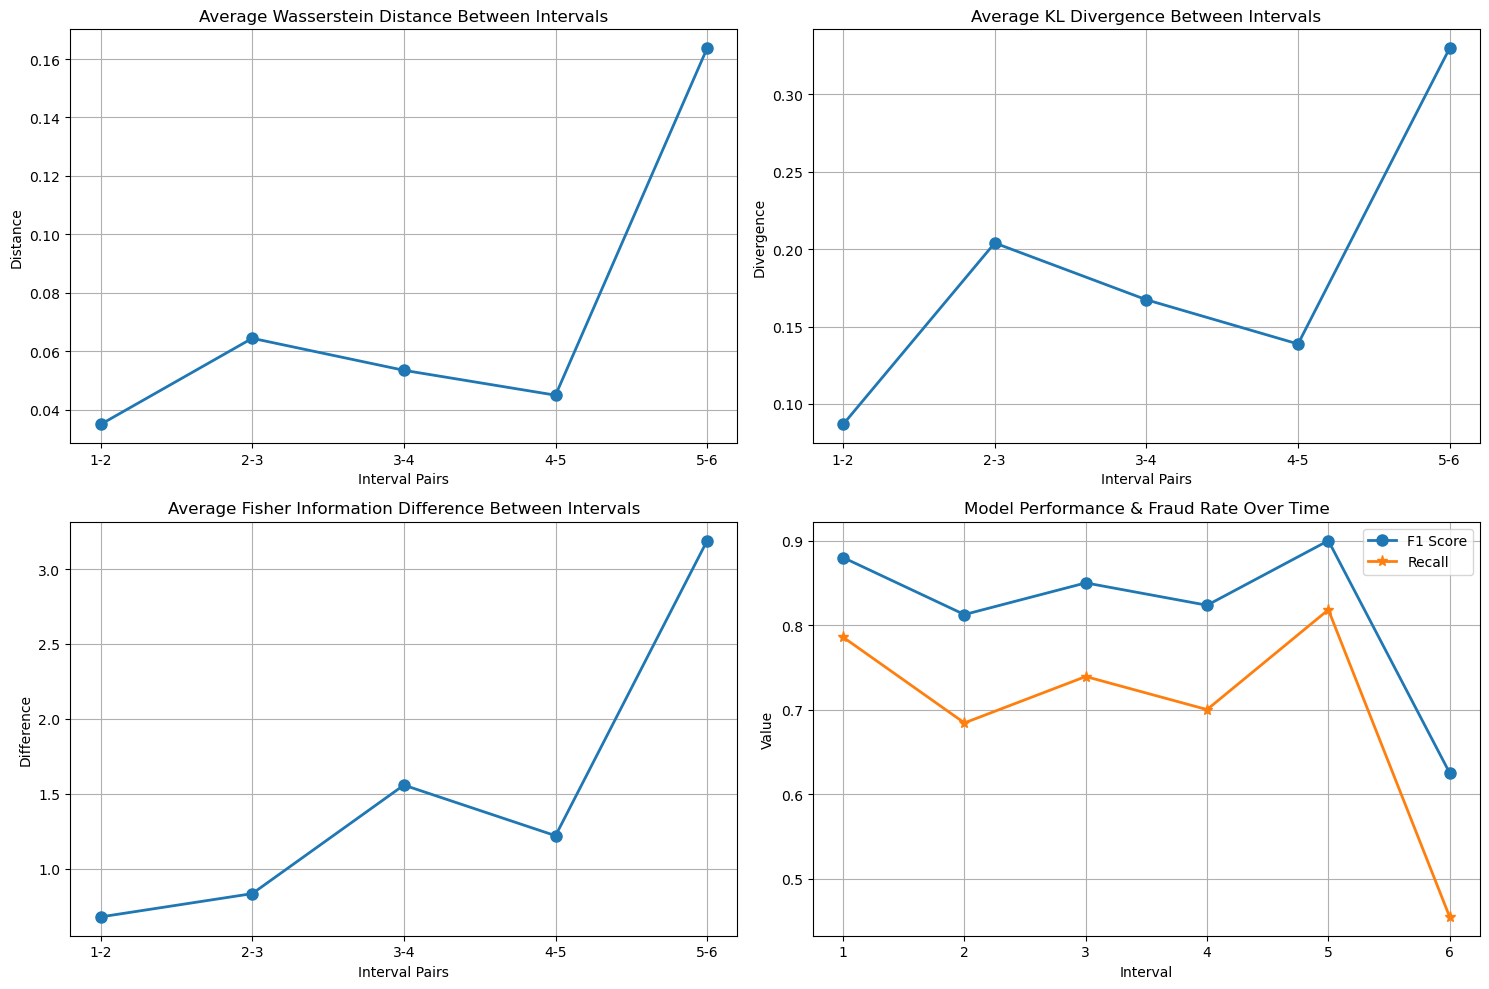

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize drift over time
plt.figure(figsize=(15, 10))

# Extract drift metrics across interval pairs
interval_pairs = [r['interval_pair'] for r in drift_results]
wasserstein_values = [r['avg_wasserstein'] for r in drift_results]
kl_values = [r['avg_kl_divergence'] for r in drift_results]
fisher_values = [r['avg_fisher_diff'] for r in drift_results]

# Plot drift metrics
plt.subplot(2, 2, 1)
plt.plot(interval_pairs, wasserstein_values, 'o-', linewidth=2, markersize=8)
plt.title('Average Wasserstein Distance Between Intervals')
plt.xlabel('Interval Pairs')
plt.ylabel('Distance')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(interval_pairs, kl_values, 'o-', linewidth=2, markersize=8)
plt.title('Average KL Divergence Between Intervals')
plt.xlabel('Interval Pairs')
plt.ylabel('Divergence')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(interval_pairs, fisher_values, 'o-', linewidth=2, markersize=8)
plt.title('Average Fisher Information Difference Between Intervals')
plt.xlabel('Interval Pairs')
plt.ylabel('Difference')
plt.grid(True)

# Plot model performance over intervals
interval_indices = list(range(1, len(intervals) + 1))
f1_scores = []
recalls = []
fraud_rates = []

for interval in intervals:
    # Calculate fraud rate in interval
    fraud_rate = interval['Class'].mean()
    fraud_rates.append(fraud_rate)
    
    # Evaluate model on interval
    X_interval = scaler.transform(interval[features])
    y_interval = interval['Class']
    y_pred_interval = model.predict(X_interval)
    
    # Calculate performance
    _, recall, f1, _ = precision_recall_fscore_support(
        y_interval, y_pred_interval, average='binary', zero_division=0)
    recalls.append(recall)
    f1_scores.append(f1)

plt.subplot(2, 2, 4)
plt.plot(interval_indices, f1_scores, 'o-', linewidth=2, markersize=8, label='F1 Score')
plt.plot(interval_indices, recalls, '*-', linewidth=2, markersize=8, label='Recall')
# plt.plot(interval_indices, fraud_rates, 's--', linewidth=2, markersize=8, label='Fraud Rate')
plt.title('Model Performance & Fraud Rate Over Time')
plt.xlabel('Interval')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
# plt.savefig('drift_analysis.png')
plt.show()

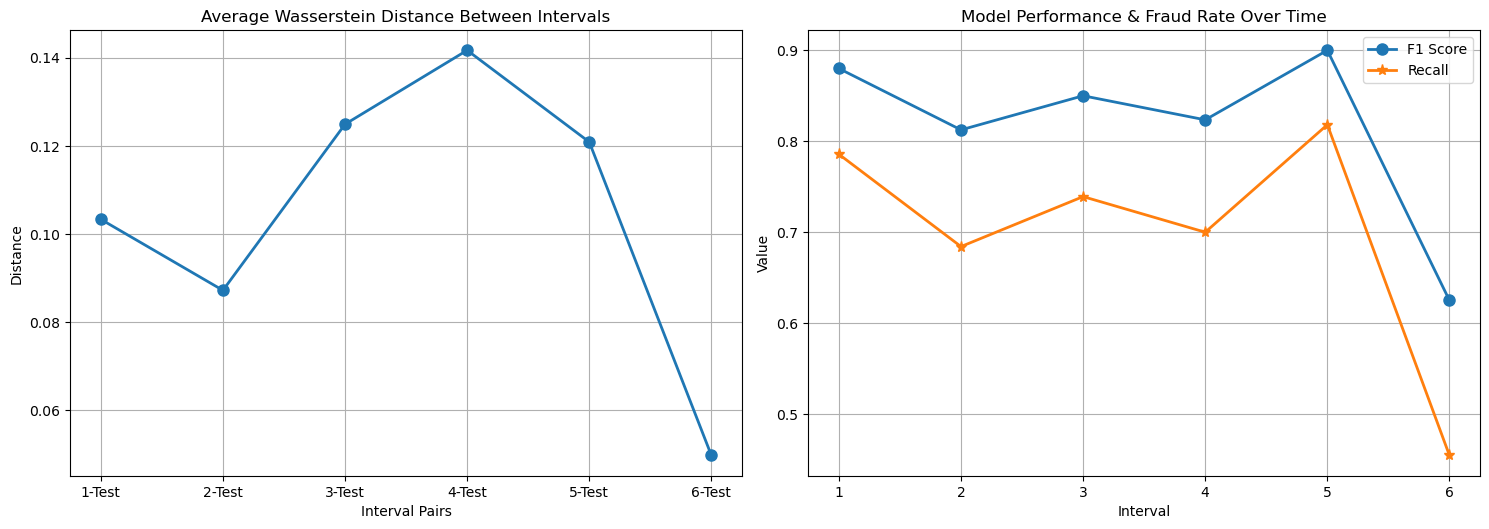

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize drift over time
plt.figure(figsize=(15, 10))

# Extract drift metrics across interval pairs
interval_pairs = [r['interval_pair'] for r in test_drift_results]
wasserstein_values = [r['avg_wasserstein'] for r in test_drift_results]
kl_values = [r['avg_kl_divergence'] for r in test_drift_results]
fisher_values = [r['avg_fisher_diff'] for r in test_drift_results]

# Plot drift metrics
plt.subplot(2, 2, 1)
plt.plot(interval_pairs, wasserstein_values, 'o-', linewidth=2, markersize=8)
plt.title('Average Wasserstein Distance Between Intervals')
plt.xlabel('Interval Pairs')
plt.ylabel('Distance')
plt.grid(True)

# plt.subplot(2, 2, 2)
# plt.plot(interval_pairs, kl_values, 'o-', linewidth=2, markersize=8)
# plt.title('Average KL Divergence Between Intervals')
# plt.xlabel('Interval Pairs')
# plt.ylabel('Divergence')
# plt.grid(True)

# plt.subplot(2, 2, 3)
# plt.plot(interval_pairs, fisher_values, 'o-', linewidth=2, markersize=8)
# plt.title('Average Fisher Information Difference Between Intervals')
# plt.xlabel('Interval Pairs')
# plt.ylabel('Difference')
# plt.grid(True)

# Plot model performance over intervals
interval_indices = list(range(1, len(intervals) + 1))
f1_scores = []
recalls = []
fraud_rates = []

for interval in intervals:
    # Calculate fraud rate in interval
    fraud_rate = interval['Class'].mean()
    fraud_rates.append(fraud_rate)
    
    # Evaluate model on interval
    X_interval = scaler.transform(interval[features])
    y_interval = interval['Class']
    y_pred_interval = model.predict(X_interval)
    
    # Calculate performance
    _, recall, f1, _ = precision_recall_fscore_support(
        y_interval, y_pred_interval, average='binary', zero_division=0)
    recalls.append(recall)
    f1_scores.append(f1)

plt.subplot(2, 2, 2)
plt.plot(interval_indices, f1_scores, 'o-', linewidth=2, markersize=8, label='F1 Score')
plt.plot(interval_indices, recalls, '*-', linewidth=2, markersize=8, label='Recall')
# plt.plot(interval_indices, fraud_rates, 's--', linewidth=2, markersize=8, label='Fraud Rate')
plt.title('Model Performance & Fraud Rate Over Time')
plt.xlabel('Interval')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
# plt.savefig('drift_analysis.png')
plt.show()

In [40]:
# Intervals 3-4:
# Average Wasserstein Distance: 0.6579
# Average KL Divergence: 0.0009
# Average Fisher Information Difference: 0.0820

# Top drifting features (Wasserstein):
# Amount: 18.0407
# V2: 0.1147
# V4: 0.0917

# plt.hist(X_train_scaled['Amount'].values,1000)
X_train_scaled
# plt.hist(intervals[3]['V2'].values,1000)
# intervals[0]

array([[-0.66333691, -0.04719226,  1.53058464, ...,  0.33490864,
        -0.07318549,  0.24044256],
       [ 0.6860085 ,  0.16179571, -0.10659749, ..., -0.02682618,
         0.04081167, -0.34984872],
       [-0.66256851, -0.82866952,  1.00338413, ..., -0.14450093,
        -0.19649166,  1.16061076],
       ...,
       [-0.28189659,  0.03284952,  0.48450675, ...,  0.17945214,
         0.31330325, -0.2722708 ],
       [-0.78523044,  0.72887953,  0.42067117, ..., -0.28086276,
        -0.40880668, -0.19879072],
       [-0.67591339, -3.47526716, -3.4251501 , ..., -1.05173024,
         0.61954667,  6.65148873]])

In [4]:
# import geomstats.backend as gs
# from geomstats.information_geometry.categorical import CategoricalDistributions
# from geomstats.information_geometry.normal import NormalDistributions
# import numpy as np

# def estimate_fisher_information_geomstats(samples, method='categorical', n_bins=30):
#     """
#     Estimate Fisher Information using geomstats library.
#     """
#     gs.random.seed(42)
    
#     if method == 'categorical':
#         # Convert continuous data to discrete distribution
#         hist, bin_edges = np.histogram(samples, bins=n_bins, density=True)
        
#         # Normalize to create a probability distribution
#         probabilities = hist / np.sum(hist)
        
#         # Add small constant to avoid issues with log(0)
#         probabilities = probabilities + 1e-10
#         probabilities = probabilities / np.sum(probabilities)
        
#         # Create categorical manifold
#         cat_manifold = CategoricalDistributions(dim=n_bins-1)
        
#         # Convert to point on the manifold
#         point = gs.array(probabilities[:-1])  # Categorical uses n-1 coordinates
        
#         # Get metric tensor at this point
#         metric_tensor = cat_manifold.metric.metric_matrix(point)
        
#         # Fisher Information is the trace of the metric
#         fisher_info = gs.trace(metric_tensor)
        
#     elif method == 'normal':
#         # Fit normal distribution to data
#         mean = np.mean(samples)
#         std = np.std(samples)
        
#         # Create normal distribution manifold
#         normal_manifold = NormalDistributions(dim=1)
        
#         # Point on manifold (mean, standard deviation)
#         point = gs.array([mean, std])
        
#         # Get Fisher Information Matrix
#         metric_tensor = normal_manifold.metric.metric_matrix(point)
        
#         # Extract Fisher Information
#         fisher_info = gs.trace(metric_tensor)
    
#     else:
#         raise ValueError("Method must be 'categorical' or 'normal'")
    
#     return fisher_info

# def calculate_fisher_rao_distance_geomstats(samples1, samples2, n_bins=30):
#     """
#     Calculate Fisher-Rao distance between two distributions using geomstats.
#     """
#     # Convert to probability distributions
#     hist1, bin_edges = np.histogram(samples1, bins=n_bins, density=True)
#     hist2, _ = np.histogram(samples2, bins=bin_edges, density=True)
    
#     # Normalize
#     p1 = hist1 / np.sum(hist1) + 1e-10
#     p1 = p1 / np.sum(p1)
    
#     p2 = hist2 / np.sum(hist2) + 1e-10
#     p2 = p2 / np.sum(p2)
    
#     # Create categorical manifold
#     cat_manifold = CategoricalDistributions(dim=n_bins-1)
    
#     # Convert to points on the manifold (using n-1 coordinates)
#     point1 = gs.array(p1[:-1])
#     point2 = gs.array(p2[:-1])
    
#     # Calculate Fisher-Rao distance
#     fisher_rao_distance = cat_manifold.metric.dist(point1, point2)
    
#     return fisher_rao_distance

# # Alternative approach using multinomial manifold if CategoricalDistributions doesn't work
# def estimate_fisher_information_multinomial(samples, n_bins=30):
#     """
#     Alternative Fisher Information estimation using multinomial approach.
#     """
#     from geomstats.information_geometry.multinomial import MultinomialDistributions
    
#     # Convert to probability distribution
#     hist, _ = np.histogram(samples, bins=n_bins, density=True)
#     probabilities = hist / np.sum(hist) + 1e-10
#     probabilities = probabilities / np.sum(probabilities)
    
#     # Create multinomial manifold
#     multinomial_manifold = MultinomialDistributions(n_draws=len(samples), dim=n_bins-1)
    
#     # Convert to point
#     point = gs.array(probabilities[:-1])
    
#     # Get metric tensor
#     metric_tensor = multinomial_manifold.metric.metric_matrix(point)
    
#     # Fisher Information
#     fisher_info = gs.trace(metric_tensor)
    
#     return fisher_info

# # Simplified approach if you're having issues with the geomstats implementation
# def estimate_fisher_information_simple(samples, n_bins=30):
#     """
#     Simplified Fisher Information estimation for categorical distributions.
#     """
#     # Convert to discrete distribution
#     hist, _ = np.histogram(samples, bins=n_bins, density=True)
    
#     # Normalize
#     probs = hist / np.sum(hist) + 1e-10
#     probs = probs / np.sum(probs)
    
#     # For categorical distribution, Fisher Information Matrix element (i,j):
#     # F_ij = δ_ij/p_i - 1/p_n (for i,j != n)
#     # where p_n is the last category probability
    
#     # For univariate case, we can approximate the Fisher Information
#     fisher_info = np.sum(1.0 / probs) - len(probs) / probs[-1]
    
#     return fisher_info

# def calculate_fisher_rao_distance_simple(samples1, samples2, n_bins=30):
#     """
#     Simplified Fisher-Rao distance calculation.
#     """
#     # Convert to probability distributions
#     hist1, bin_edges = np.histogram(samples1, bins=n_bins, density=True)
#     hist2, _ = np.histogram(samples2, bins=bin_edges, density=True)
    
#     # Normalize
#     p1 = hist1 / np.sum(hist1) + 1e-10
#     p1 = p1 / np.sum(p1)
    
#     p2 = hist2 / np.sum(hist2) + 1e-10
#     p2 = p2 / np.sum(p2)
    
#     # Fisher-Rao distance approximation
#     # Using the arc-cosine formula for probability distributions
#     fisher_rao_distance = 2 * np.arccos(np.sum(np.sqrt(p1 * p2)))
    
#     return fisher_rao_distance

# # Update your drift detection function to use geomstats
# def detect_distribution_drift_geomstats(intervals, features):
#     """Detect drift using geomstats information geometry tools."""
#     results = []
    
#     for i in range(len(intervals) - 1):
#         interval_drifts = []
        
#         current_data = intervals[i]
#         next_data = intervals[i+1]
        
#         for feature in features[:3]:
#             if features.index(feature) % 2 == 0:
#                 print(f"On Feature {features.index(feature)} of {len(features)}")

#             current_dist = current_data[feature].values
#             next_dist = next_data[feature].values
            
#             # Calculate Wasserstein distance
#             w_dist = calculate_wasserstein_distance(current_dist, next_dist)
            
#             # Calculate KL divergence
#             kl_div = calculate_kl_divergence(current_dist, next_dist)
            
#             # Calculate Fisher Information using geomstats
#             fisher_current_cat = estimate_fisher_information_geomstats(current_dist, method='categorical')
#             fisher_next_cat = estimate_fisher_information_geomstats(next_dist, method='categorical')
#             fisher_diff_cat = abs(fisher_current_cat - fisher_next_cat)
            
#             # For comparison, also calculate with normal distribution assumption
#             fisher_current_norm = estimate_fisher_information_geomstats(current_dist, method='normal')
#             fisher_next_norm = estimate_fisher_information_geomstats(next_dist, method='normal')
#             fisher_diff_norm = abs(fisher_current_norm - fisher_next_norm)
            
#             # Calculate Fisher-Rao distance
#             fisher_rao_dist = calculate_fisher_rao_distance_geomstats(current_dist, next_dist)
            
#             interval_drifts.append({
#                 'feature': feature,
#                 'wasserstein': w_dist,
#                 'kl_divergence': kl_div,
#                 'fisher_diff_categorical': fisher_diff_cat,
#                 'fisher_diff_normal': fisher_diff_norm,
#                 'fisher_rao_distance': fisher_rao_dist
#             })
        
#         results.append({
#             'interval_pair': f"{i+1}-{i+2}",
#             'feature_drifts': interval_drifts,
#             'avg_wasserstein': np.mean([d['wasserstein'] for d in interval_drifts]),
#             'avg_kl_divergence': np.mean([d['kl_divergence'] for d in interval_drifts]),
#             'avg_fisher_diff_categorical': np.mean([d['fisher_diff_categorical'] for d in interval_drifts]),
#             'avg_fisher_diff_normal': np.mean([d['fisher_diff_normal'] for d in interval_drifts]),
#             'avg_fisher_rao_distance': np.mean([d['fisher_rao_distance'] for d in interval_drifts])
#         })
    
#     return results

# # Run geomstats-based drift detection
# geomstats_results = detect_distribution_drift_geomstats(intervals, features)

# # Print results
# print("\nDrift Detection Results (Geomstats):")
# for result in geomstats_results:
#     print(f"\nIntervals {result['interval_pair']}:")
#     print(f"Average Wasserstein Distance: {result['avg_wasserstein']:.4f}")
#     print(f"Average KL Divergence: {result['avg_kl_divergence']:.4f}")
#     print(f"Average Fisher Difference (Categorical): {result['avg_fisher_diff_categorical']:.4f}")
#     print(f"Average Fisher Difference (Normal): {result['avg_fisher_diff_normal']:.4f}")
#     print(f"Average Fisher-Rao Distance: {result['avg_fisher_rao_distance']:.4f}")

NameError: name 'result' is not defined